In [18]:
import tensorflow as tf
import numpy as np
import keras
import os
import matplotlib
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.layers import Dense, Conv2D, Flatten,Conv2DTranspose, Reshape, Dropout, Input
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from PIL import Image

In [19]:
np.random.seed(10)  #for consistency of random numbers and our images

noise_dim = 100  # input dimension of random vector - the vector that goes into the generator

batch_size = 16   #How many images do we want to include in each batch
steps_per_epoch = 3750  #How many steps do we want to take per iteration of our training set (number of batches)
epochs = 10      #How many iterations of our training set do we want to do.

#change the below values to the dimensions of your image. The channels number refers to the number of colors
img_rows, img_cols, channels = 28, 28, 1

#These are the recommended values for the optimizer
optimizer = Adam(0.0002, 0.5)

In [20]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()   #Load the data

x_train = (x_train.astype(np.float32) - 127.5) / 127.5       #Normalize the images again so that the pixel value is from -1 to 1

x_train = x_train.reshape(-1, img_rows, img_cols, channels)  #Reshaping the data into a more NN friendly format

In [21]:
def create_generator_cgan():
    generator = Sequential()
    
    d = 7
    generator.add(Dense(d*d*256, kernel_initializer=RandomNormal(0, 0.02), input_dim=noise_dim))
    generator.add(LeakyReLU(0.2))     #We are going to use the same leaky relu activation function as the FCGAN.
    
    generator.add(Reshape((d, d, 256)))
    
    generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))
       
       
    generator.add(Conv2D(channels, (3, 3), padding='same', activation='tanh', kernel_initializer=RandomNormal(0, 0.02)))  #Remember that the final activation has to be tanh, since pixel values go from -1 to 1
    
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)    #The loss doesn't change when you use convolutional layers
    return generator

In [22]:
def create_discriminator_cgan():
    discriminator = Sequential()
    
    discriminator.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(img_cols, img_rows, channels)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(256, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Flatten())
    discriminator.add(Dropout(0.4))
    discriminator.add(Dense(1, activation='sigmoid', input_shape=(img_cols, img_rows, channels)))

    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)  #Again, the loss doesn't change when creating a DCGAN.
    return discriminator

In [24]:
discriminator = create_discriminator_cgan()
generator = create_generator_cgan()

discriminator.trainable = False

gan_input = Input(shape=(noise_dim,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

In [25]:
#on veut generer que des manteau donc on met dans le jeu d'entrainement que des manteau
x_train = x_train[np.where(y_train == 4)[0]]

In [26]:
#afficher un sample d'image généré par le generator
def show_images(noise, size_fig):
    generated_images = generator.predict(noise)   #Create the images from the GAN.
    plt.figure(figsize=size_fig)
    
    for i, image in enumerate(generated_images):
        plt.subplot(size_fig[0], size_fig[1], i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')    #If the image is grayscale, as in our case, then we will reshape the output in the following way.
                                                                            #Also, we set the coloring to grayscale so that it doesn't look like it came out of an infrared camera :)
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()   #Tight layout so that all of the generated images form a nice grid
    plt.show()

Epoch: 1 	 Discriminator Loss: 0.6203782558441162 		 Generator Loss: 0.9421600103378296


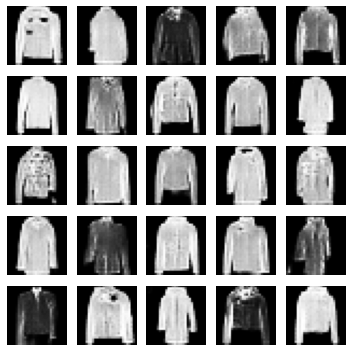

Epoch: 2 	 Discriminator Loss: 0.5954609513282776 		 Generator Loss: 1.1726778745651245


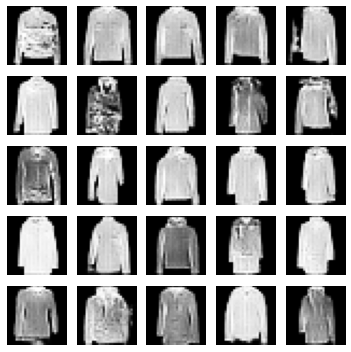

Epoch: 3 	 Discriminator Loss: 0.6696214079856873 		 Generator Loss: 0.9758740663528442


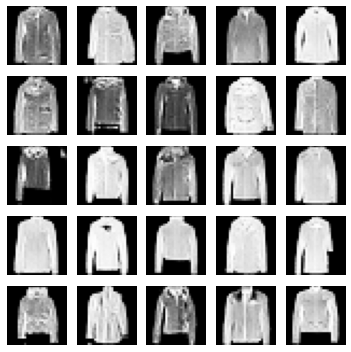

Epoch: 4 	 Discriminator Loss: 0.6544809341430664 		 Generator Loss: 1.0226695537567139


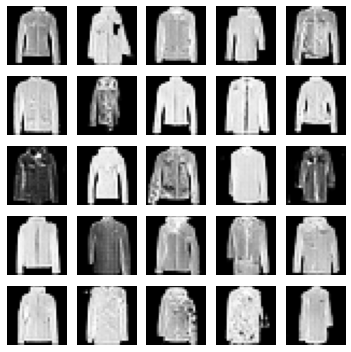

Epoch: 5 	 Discriminator Loss: 0.6444547772407532 		 Generator Loss: 1.0946519374847412


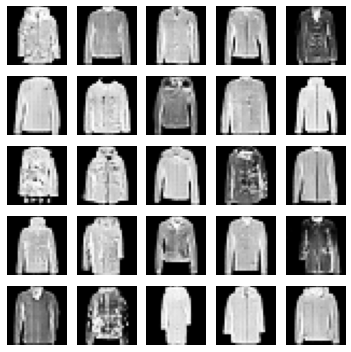

Epoch: 6 	 Discriminator Loss: 0.5775622725486755 		 Generator Loss: 1.4040107727050781


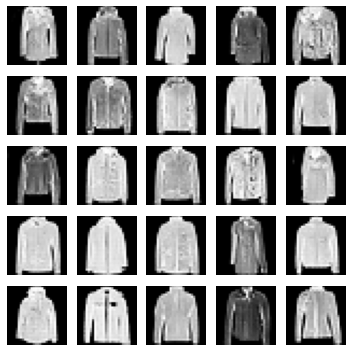

Epoch: 7 	 Discriminator Loss: 0.5363224744796753 		 Generator Loss: 1.299944519996643


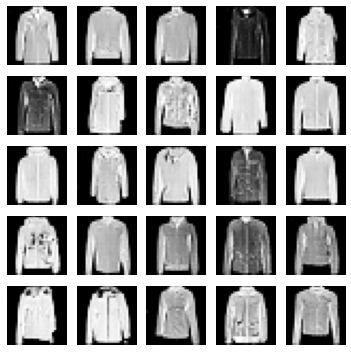

Epoch: 8 	 Discriminator Loss: 0.5680935382843018 		 Generator Loss: 1.8087501525878906


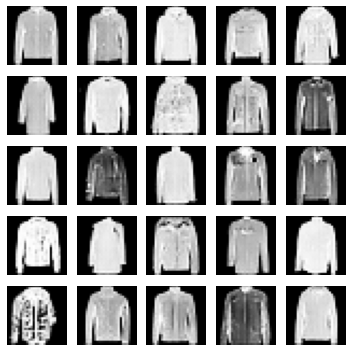

Epoch: 9 	 Discriminator Loss: 0.5245707035064697 		 Generator Loss: 1.4164655208587646


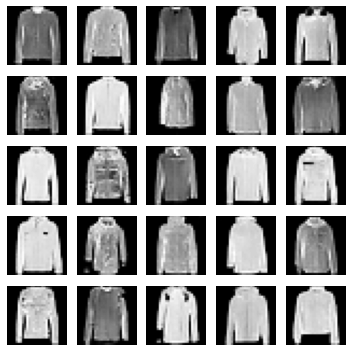

Epoch: 10 	 Discriminator Loss: 0.6298507452011108 		 Generator Loss: 1.6679015159606934


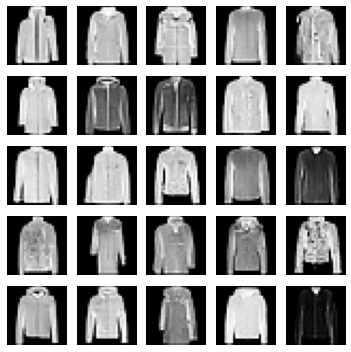

In [27]:
G_loss=[]
D_loss=[]
#on entraine le model GAN 
for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
        fake_x = generator.predict(noise)

        real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
        #print(real_x.shape)
        #print(fake_x.shape)
        x = np.concatenate((real_x, fake_x))

        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9

        d_loss = discriminator.train_on_batch(x, disc_y)
        D_loss.append(d_loss)

        y_gen = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, y_gen)
        G_loss.append(g_loss)

    print(f'Epoch: {epoch + 1} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')
    noise = np.random.normal(0, 1, size=(25, noise_dim))
    show_images(noise, (5, 5))

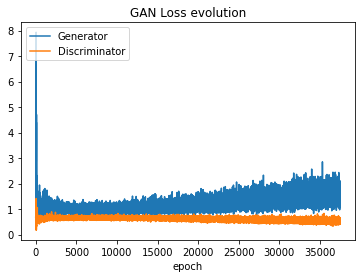

In [28]:
#Show the Generator-Descriminator loss for every epoch
def plot_gan_losses(G_loss, D_loss):
    plt.plot(G_loss)
    plt.plot(D_loss)
    plt.title('GAN Loss evolution')
    plt.ylabel('')
    plt.xlabel('epoch')
    plt.legend(['Generator', 'Discriminator'], loc='upper left')
    plt.show()
  
plot_gan_losses(G_loss, D_loss)

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
import os
os.listdir("./")
os.listdir("./drive/MyDrive/lifprojet")

['generator_tshirt.h5', 'images', 'generator_pantalon.h5', 'generator_pull.h5']

In [29]:
generator.save('./drive/MyDrive/lifprojet/generator_manteau.h5')

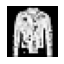

In [30]:
#afficher une image généré par le generator
def show_one_generate_image():
    noise = np.random.normal(0, 1, size=(1, 100))
    size_fig=(1,1)
    generated_images = generator.predict(noise)   #Create the images from the GAN.
    plt.figure(figsize=size_fig)
    
    for i, image in enumerate(generated_images):
        plt.subplot(size_fig[0], size_fig[1], i+1)
        #fig=plt.subplot(size_fig[0], size_fig[1], i+1)
        if channels == 1:
            img=image.reshape((img_rows, img_cols))
            plt.imshow(img, cmap='gray')    #If the image is grayscale, as in our case, then we will reshape the output in the following way.
                                            #Also, we set the coloring to grayscale so that it doesn't look like it came out of an infrared camera :)
            #fig.savefig("./drive/MyDrive/lifprojet/images/fig_category0.png")
            matplotlib.image.imsave('./drive/MyDrive/lifprojet/images/COLORcategory0.png', img)
            color_image=Image.open( "./drive/MyDrive/lifprojet/images/COLORcategory0.png")
            bw_image=color_image.convert('L')
            bw_image.save("./drive/MyDrive/lifprojet/images/BWcategory0.png")
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()   #Tight layout so that all of the generated images form a nice grid
    plt.show()
    
show_one_generate_image()

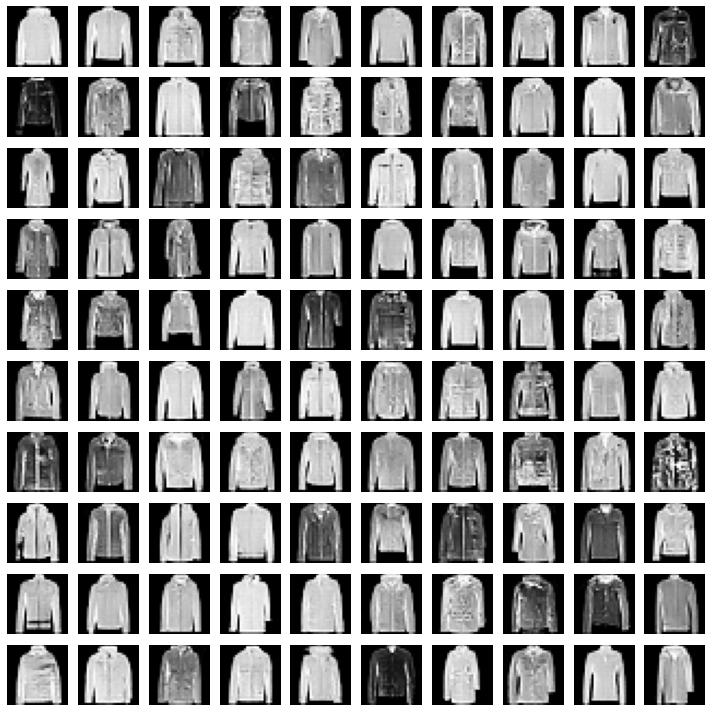

In [31]:
#afficher un sample de 100 images généré par le generator
def show_100_generate_images():
    noise = np.random.normal(0, 1, size=(100, 100))
    size_fig=(10,10)
    generated_images = generator.predict(noise)   #Create the images from the GAN.

    plt.figure(figsize=size_fig)
    
    for i, image in enumerate(generated_images):
        plt.subplot(size_fig[0], size_fig[1], i+1)
        if channels == 1:
            img=image.reshape((img_rows, img_cols))
            plt.imshow(img, cmap='gray')    #If the image is grayscale, as in our case, then we will reshape the output in the following way.
                                                                            #Also, we set the coloring to grayscale so that it doesn't look like it came out of an infrared camera :)
            matplotlib.image.imsave('./drive/MyDrive/lifprojet/images/COLORcategory0_%d.png' % i, img)
            color_image=Image.open( "./drive/MyDrive/lifprojet/images/COLORcategory0_%d.png" % i)
            bw_image=color_image.convert('L')
            bw_image.save("./drive/MyDrive/lifprojet/images/BWcategory0_%d.png" % i)                                                                 
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()   #Tight layout so that all of the generated images form a nice grid
    plt.show()
    
show_100_generate_images()